<a href="https://colab.research.google.com/github/angelrodriguez0617/CS-4710-Machine-Learning-II/blob/main/A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Angel Rodriguez, February 9, 2024
Phantom Generation

# CS 4710 A4.ipynb


1. The model has a total of **24 layers** including the input and output layers.
2. The number of channels (filters) at each layer is as follows:
    - **Input Layer**: 1 channel (assuming grayscale images)
    - **Conv2D Layer 1**: 128 channels
    - **BatchNormalization Layer 1**
    - **Conv2D Layer 2**: 128 channels
    - **BatchNormalization Layer 2**
    - **Conv2D Layer 3**: 256 channels
    - **BatchNormalization Layer 3**
    - **Conv2D Layer 4**: 256 channels
    - **BatchNormalization Layer 4**
    - **Conv2D Layer 5**: 512 channels
    - **BatchNormalization Layer 5**
    - **Conv2D Layer 6**: 512 channels
    - **BatchNormalization Layer 6**
    - **Dropout Layer**
    - **Conv2DTranspose Layer 1**: 512 channels
    - **BatchNormalization Layer 7**
    - **Conv2DTranspose Layer 2**: 256 channels
    - **BatchNormalization Layer 8**
    - **Conv2DTranspose Layer 3**: 256 channels
    - **BatchNormalization Layer 9**
    - **Conv2DTranspose Layer 4**: 128 channels
    - **BatchNormalization Layer 10**
    - **Conv2DTranspose Layer 5**: 64 channels
    - **BatchNormalization Layer 11**
    - **Output Layer (Conv2DTranspose Layer 6)**: 64 channels

3. Parameters Used:
- Total params: 9234563 (35.23 MB)
- Trainable params: 9228291 (35.20 MB)
- Non-trainable params: 6272 (24.50 KB)

4. final val_loss: 0.0556



## Load the Shepp-Logan phantom and generate its sinogram (a.k.a. Radon transform, projections)
https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html

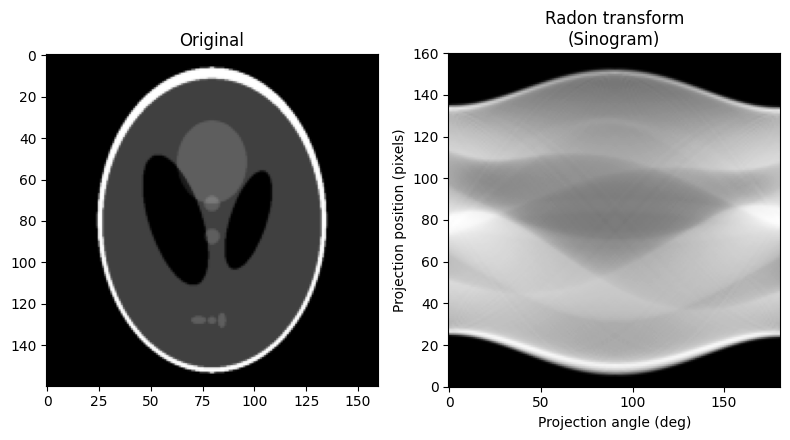

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()

## Denoising using simuated data

** Phantom Generator **

In [5]:
## Copyright (C) 2010  Alex Opie  <lx_op@orcon.net.nz>
##
## This program is free software; you can redistribute it and/or modify it
## under the terms of the GNU General Public License as published by
## the Free Software Foundation; either version 3 of the License, or (at
## your option) any later version.
##
## This program is distributed in the hope that it will be useful, but
## WITHOUT ANY WARRANTY; without even the implied warranty of
## MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.	See the GNU
## General Public License for more details.
##
## You should have received a copy of the GNU General Public License
## along with this program; see the file COPYING.  If not, see
## <http://www.gnu.org/licenses/>.

import numpy as np

def phantom (n = 64, p_type = 'Modified Shepp-Logan', ellipses = None):
	"""
	 phantom (n = 256, p_type = 'Modified Shepp-Logan', ellipses = None)

	Create a Shepp-Logan or modified Shepp-Logan phantom.

	A phantom is a known object (either real or purely mathematical)
	that is used for testing image reconstruction algorithms.  The
	Shepp-Logan phantom is a popular mathematical model of a cranial
	slice, made up of a set of ellipses.  This allows rigorous
	testing of computed tomography (CT) algorithms as it can be
	analytically transformed with the radon transform (see the
	function `radon').

	Inputs
	------
	n : The edge length of the square image to be produced.

	p_type : The type of phantom to produce. Either
	  "Modified Shepp-Logan" or "Shepp-Logan".  This is overridden
	  if `ellipses' is also specified.

	ellipses : Custom set of ellipses to use.  These should be in
	  the form
	  	[[I, a, b, x0, y0, phi],
	  	 [I, a, b, x0, y0, phi],
	  	 ...]
	  where each row defines an ellipse.
	  I : Additive intensity of the ellipse.
	  a : Length of the major axis.
	  b : Length of the minor axis.
	  x0 : Horizontal offset of the centre of the ellipse.
	  y0 : Vertical offset of the centre of the ellipse.
	  phi : Counterclockwise rotation of the ellipse in degrees,
	        measured as the angle between the horizontal axis and
	        the ellipse major axis.
	  The image bounding box in the algorithm is [-1, -1], [1, 1],
	  so the values of a, b, x0, y0 should all be specified with
	  respect to this box.

	Output
	------
	P : A phantom image.

	Usage example
	-------------
	  import matplotlib.pyplot as pl
	  P = phantom ()
	  pl.imshow (P)

	References
	----------
	Shepp, L. A.; Logan, B. F.; Reconstructing Interior Head Tissue
	from X-Ray Transmissions, IEEE Transactions on Nuclear Science,
	Feb. 1974, p. 232.

	Toft, P.; "The Radon Transform - Theory and Implementation",
	Ph.D. thesis, Department of Mathematical Modelling, Technical
	University of Denmark, June 1996.

	"""

	if (ellipses is None):
		ellipses = _select_phantom (p_type)
	elif (np.size (ellipses, 1) != 6):
		raise AssertionError ("Wrong number of columns in user phantom")

	# Blank image
	p = np.zeros ((n, n))

	# Create the pixel grid
	ygrid, xgrid = np.mgrid[-1:1:(1j*n), -1:1:(1j*n)]

	for ellip in ellipses:
		I   = ellip [0]
		a2  = ellip [1]**2
		b2  = ellip [2]**2
		x0  = ellip [3]
		y0  = ellip [4]
		phi = ellip [5] * np.pi / 180  # Rotation angle in radians

		# Create the offset x and y values for the grid
		x = xgrid - x0
		y = ygrid - y0

		cos_p = np.cos (phi)
		sin_p = np.sin (phi)

		# Find the pixels within the ellipse
		locs = (((x * cos_p + y * sin_p)**2) / a2
              + ((y * cos_p - x * sin_p)**2) / b2) <= 1

		# Add the ellipse intensity to those pixels
		p [locs] += I

	return p


def _select_phantom (name):
	if (name.lower () == 'shepp-logan'):
		e = _shepp_logan ()
	elif (name.lower () == 'modified shepp-logan'):
		e = _mod_shepp_logan ()
	else:
		raise ValueError ("Unknown phantom type: %s" % name)

	return e


def _shepp_logan ():
	#  Standard head phantom, taken from Shepp & Logan
	return [[   2,   .69,   .92,    0,      0,   0],
	        [-.98, .6624, .8740,    0, -.0184,   0],
	        [-.02, .1100, .3100,  .22,      0, -18],
	        [-.02, .1600, .4100, -.22,      0,  18],
	        [ .01, .2100, .2500,    0,    .35,   0],
	        [ .01, .0460, .0460,    0,     .1,   0],
	        [ .02, .0460, .0460,    0,    -.1,   0],
	        [ .01, .0460, .0230, -.08,  -.605,   0],
	        [ .01, .0230, .0230,    0,  -.606,   0],
	        [ .01, .0230, .0460,  .06,  -.605,   0]]

def _mod_shepp_logan ():
	#  Modified version of Shepp & Logan's head phantom,
	#  adjusted to improve contrast.  Taken from Toft.
	return [[   1,   .69,   .92,    0,      0,   0],
	        [-.80, .6624, .8740,    0, -.0184,   0],
	        [-.20, .1100, .3100,  .22,      0, -18],
	        [-.20, .1600, .4100, -.22,      0,  18],
	        [ .10, .2100, .2500,    0,    .35,   0],
	        [ .10, .0460, .0460,    0,     .1,   0],
	        [ .10, .0460, .0460,    0,    -.1,   0],
	        [ .10, .0460, .0230, -.08,  -.605,   0],
	        [ .10, .0230, .0230,    0,  -.606,   0],
	        [ .10, .0230, .0460,  .06,  -.605,   0]]

#def ?? ():
#	# Add any further phantoms of interest here
#	return np.array (
#	 [[ 0, 0, 0, 0, 0, 0],
#	  [ 0, 0, 0, 0, 0, 0]])




In [6]:

import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.transform import iradon
from skimage.util import random_noise
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

# generate data
image_size = 64
num_phantoms = 1000
theta = np.arange(0, 360)
noise_factor = 0.01     #0.05
noisy_sino = []
clean_sino = []
noisy_sinoV = []
clean_sinoV = []
clean_phan = []

sino_size1 = 64
sino_size2 = 360

for i in range(num_phantoms):

    a = np.random.randint(20,30,2)
    print(a)


    x=np.random.random(24)

    E = [[   x[ 0]-0.0,   0.6*x[ 1]+0.2,   0.8*x[ 2]+0.2,    0.1*(x[ 3]-0.5),      0.1*(x[ 4]-0.5),   10*x[ 5]   ],
         [   x[ 6]-0.1,   0.3*x[ 7]+0.2,   0.2*x[ 8]+0.2,    x[ 9]-0.5,      x[10]-0.5,   100*x[11]   ],
         [   x[12]-0.2,   0.2*x[13]+0.2,   0.3*x[14]+0.2,    x[15]-0.5,      x[16]-0.5,   100*x[17]   ],
         [   x[18]-0.3,   0.1*x[19]+0.2,   0.1*x[20]+0.2,    x[21]-0.5,      x[22]-0.5,   100*x[23]  ]]
    P = phantom (n = image_size, p_type = 'ellipses', ellipses = E)
    sinogram = radon(P, theta=theta)
    sinogrammax = np.max(sinogram )
    sinogram0 = sinogram/(2*sinogrammax)
    sinogram0 = np.maximum(0, sinogram0)
    sinogram0 = np.minimum(0.5, sinogram0)

    sinogram1  = sinogram0 + noise_factor * tf.random.normal(shape=sinogram0.shape)


    # sinogram1 = random_noise(sinogram/1000, mode='poisson', seed=None, clip=True)
    sinogram1 = np.maximum(0, sinogram1)
    sinogram1 = np.minimum(1, sinogram1)

    clean_phan.append(P)    # Phantomss

    if i < 0.9*num_phantoms:
        noisy_sino.append(sinogram1)    # Data
        clean_sino.append(sinogram0)    # Targets
    else:
        noisy_sinoV.append(sinogram1)    # Data
        clean_sinoV.append(sinogram0)    # Targets

np_noisy_sino = np.asarray(noisy_sino)
np_clean_sino = np.asarray(clean_sino)
np_noisy_sinoV = np.asarray(noisy_sinoV)
np_clean_sinoV = np.asarray(clean_sinoV)
np_clean_phan = np.asarray(clean_phan)

# prepare data axes as expected by models
np_noisy = np.expand_dims(np_noisy_sino, axis=-1)
np_clean = np.expand_dims(np_clean_sino, axis=-1)
np_noisyV = np.expand_dims(np_noisy_sinoV, axis=-1)
np_cleanV = np.expand_dims(np_clean_sinoV, axis=-1)
np_phan = np.expand_dims(np_clean_phan, axis=-1)
print(np.shape(np_noisy))



[25 29]
[28 26]
[22 20]
[26 25]
[23 28]
[23 26]
[23 23]
[25 28]


/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


[29 21]
[25 23]
[25 24]
[23 25]
[24 28]
[21 27]
[29 26]
[29 28]
[28 25]
[26 23]
[23 25]
[25 24]
[20 25]
[21 27]
[26 27]
[27 27]
[24 22]
[25 21]
[26 28]
[23 24]
[25 23]
[26 29]
[20 23]
[23 28]
[21 29]
[27 25]
[28 22]
[21 25]
[22 22]
[20 23]
[29 21]
[27 21]
[28 21]
[20 29]
[24 26]
[21 23]
[22 20]
[27 23]
[28 28]
[25 28]
[23 29]
[21 20]
[23 21]
[26 22]
[29 22]
[26 26]
[20 21]
[27 20]
[26 20]
[25 26]
[25 26]
[26 28]
[28 24]
[22 22]
[29 24]
[21 21]
[29 22]
[29 23]
[22 21]
[28 20]
[20 26]
[27 21]
[29 21]
[21 25]
[22 28]
[27 20]
[23 20]
[29 24]
[29 25]
[24 20]
[29 29]
[27 29]
[21 26]
[28 27]
[23 28]
[26 25]
[24 20]
[24 29]
[26 25]
[21 26]
[22 29]
[24 28]
[29 22]
[21 28]
[27 24]
[24 26]
[25 20]
[25 24]
[28 24]
[29 28]
[23 24]
[27 20]
[29 27]
[22 23]
[24 27]
[28 27]
[27 23]
[24 28]
[21 20]
[28 20]
[23 25]
[23 20]
[29 28]
[22 28]
[24 27]
[26 29]
[29 28]
[29 26]
[22 25]
[20 23]
[20 23]
[28 22]
[28 26]
[25 23]
[20 25]
[21 27]
[22 24]
[21 25]
[21 21]
[24 29]
[27 27]
[23 26]
[23 28]
[29 28]
[21 20]


In [7]:
#np_noisy = np_noisy/np.max(np_noisy)
print(np.max(np_noisy))
print(np.max(np_clean))

0.5369451
0.5


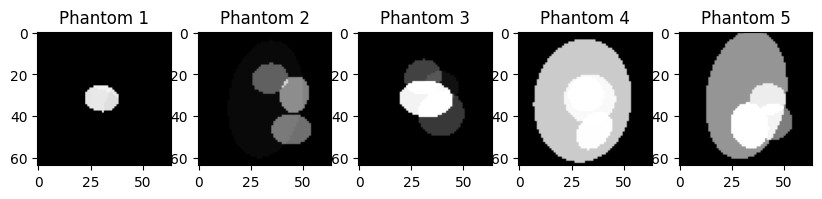

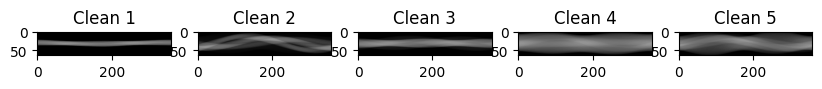

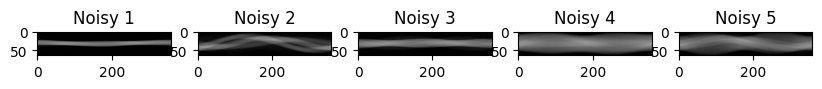

In [8]:
# Display some phantoms

fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for idx, ax in enumerate(axs):
    ax.imshow(np_phan[idx], cmap=plt.cm.Greys_r, vmin=0, vmax=1)
    ax.set_title(f"Phantom {idx+1}")
fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for idx, ax in enumerate(axs):
    ax.imshow(np_clean[idx], cmap=plt.cm.Greys_r, vmin=0, vmax=1)
    ax.set_title(f"Clean {idx+1}")
fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for idx, ax in enumerate(axs):
    ax.imshow(np_noisy[idx], cmap=plt.cm.Greys_r, vmin=0, vmax=1)
    ax.set_title(f"Noisy {idx+1}")
plt.show()

## Model 2: U-Net

In [10]:
# def get_model(img_size, num_classes):
#  inputs = keras.Input(shape=img_size + (1,))
#  x = layers.Rescaling(1./255)(inputs)
#  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
#  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
#  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
#  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
#  x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
#  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
#  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
#  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
#  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
#  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
#  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
#  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
#  outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
#  model = keras.Model(inputs, outputs)
#  return model

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))
    x = layers.Rescaling(1./255)(inputs)

    # Increased the number of filters and added Batch Normalization
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(512, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Added Dropout to prevent overfitting
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2DTranspose(512, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

img_size = (64, 360)
model = get_model(img_size=img_size, num_classes=3)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 360, 1)]      0         
                                                                 
 rescaling (Rescaling)       (None, 64, 360, 1)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 180, 128)      1280      
                                                                 
 batch_normalization (Batch  (None, 32, 180, 128)      512       
 Normalization)                                                  
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 180, 128)      147584    
                                                                 
 batch_normalization_1 (Bat  (None, 32, 180, 128)      512       
 chNormalization)                                            

In [ ]:
model.compile(optimizer='adam', loss='mse')

#optimizer = keras.optimizers.Adam(lr=0.01)
#model.compile(loss='mse', optimizer=optimizer)

model.fit(np_noisy,
          np_clean,
          epochs=100,
          shuffle=True,
          validation_data=(np_noisyV, np_cleanV))


Epoch 1/100
22/29 [=====================>........] - ETA: 4:10 - loss: 0.0658

In [ ]:
decoded_imgs=model(np_noisyV).numpy()

n = 10
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n):
  # display original + noise
  bx = plt.subplot(3, n, i + 1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(np_noisyV[i]))
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)

  # display reconstruction
  cx = plt.subplot(3, n, i + n + 1)
  plt.title("reconstructed")
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  cx.get_xaxis().set_visible(False)
  cx.get_yaxis().set_visible(False)

  # display original
  ax = plt.subplot(3, n, i + 2*n + 1)
  plt.title("original")
  plt.imshow(tf.squeeze(np_cleanV[i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
import numpy as np

x0 = np_noisyV[1,:,:,:]
x0 = np.expand_dims(x0, axis=0)
print(x0.shape)
y0 = model(x0).numpy()
z0 = np_cleanV[1,:,:,:]


x1 = np.squeeze(x0)
y1 = np.squeeze(y0)
z1 = np.squeeze(z0)
print(x1.shape)

fbpx = iradon(x1, theta=theta, filter_name='ramp')
fbpy = iradon(y1, theta=theta, filter_name='ramp')
fbpz = iradon(z1, theta=theta, filter_name='ramp')
plt.axis("off")
plt.imshow(fbpz),plt.title('clean')
plt.show()
plt.axis("off")
plt.imshow(fbpx),plt.title('noisy')
plt.show()
plt.axis("off")
plt.imshow(fbpy),plt.title('processed')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(np.squeeze(x0[0]).astype("float")),plt.title('noisy')
plt.show()
plt.axis("off")
plt.imshow(np.squeeze(y0[0]).astype("float")),plt.title('processed')
plt.show()

In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(x0)

first_layer_activation = activations[0]
print(first_layer_activation.shape, first_layer_activation.shape[3])
second_layer_activation = activations[1]
print(second_layer_activation.shape, second_layer_activation.shape[3])
third_layer_activation = activations[2]
print(third_layer_activation.shape, third_layer_activation.shape[3])
fourth_layer_activation = activations[3]
print(fourth_layer_activation.shape, fourth_layer_activation.shape[3])


In [ ]:
import matplotlib.pyplot as plt
for i in range(first_layer_activation.shape[3]):
    plt.matshow(first_layer_activation[0, :, :, i], cmap=plt.cm.Greys_r,),plt.title('Layer 1 output')

for i in range(second_layer_activation.shape[3]):
    plt.matshow(second_layer_activation[0, :, :, i], cmap=plt.cm.Greys_r,),plt.title('Layer 2 output')

for i in range(third_layer_activation.shape[3]):
    plt.matshow(third_layer_activation[0, :, :, i], cmap=plt.cm.Greys_r,),plt.title('Layer 3 output')

for i in range(fourth_layer_activation.shape[3]):
    plt.matshow(fourth_layer_activation[0, :, :, i], cmap=plt.cm.Greys_r,),plt.title('Layer 4 output')


In [ ]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D)):
        print(layer.name)

In [ ]:
model.summary()

In [ ]:
ZERO = model.layers[0].get_weights()[0]
ONE = model.layers[1].get_weights()[0]
TWO = model.layers[2].get_weights()[0]
THREE = model.layers[3].get_weights()[0]
print(ZERO.shape, ONE.shape, TWO.shape, THREE.shape)
ZERO = np.transpose(ZERO, (3, 2, 0, 1 ))
ONE = np.transpose(ONE, (2, 3, 0, 1))
TWO = np.transpose(TWO, (2, 3, 0, 1))
THREE = np.transpose(THREE, (2, 3, 0, 1))
print('First layer weights =')
print(ZERO)
print('Second layer weights =')
print(ONE)
print('Third layer weights =')
print(TWO)
print('Fourth layer weights =')
print(THREE)

print(ZERO.shape)
print(ONE.shape)
print(TWO.shape)
print(THREE.shape)
# plt.matshow(ZERO[1, 0, :, :], cmap=plt.cm.Greys_r,)

In [ ]:
n = first_layer_activation.shape[3]
print(n)


#plt.gray()

g = plt.figure(figsize=(6,3))
for i in range(2):
    ax = g.add_subplot(1, 2, i + 1)
    ax.matshow(ZERO[i, 0, :, :])
plt.title("First layer weights")
plt.show()

f = plt.figure(figsize=(12,3))
for i in range(2):
    ax = f.add_subplot(1, 4, i + 1)
    ax.matshow(ONE[i, 0, :, :])
    ax = f.add_subplot(1, 4, i + 3)
    ax.matshow(ONE[i, 1, :, :])
plt.title("Second layer weights")
plt.show()

f = plt.figure(figsize=(12,3))
for i in range(2):
    ax = f.add_subplot(1, 4, i +  1)
    ax.matshow(TWO[i, 0, :, :])
    ax = f.add_subplot(1, 4, i + 3)
    ax.matshow(TWO[i, 1, :, :])
plt.title("Third layer weights")
plt.show()

h = plt.figure(figsize=(6,3))
for i in range(2):
    ax = h.add_subplot(1, 2, i + 1)
    ax.matshow(THREE[i, 0, :, :], cmap=plt.cm.Greys_r)
plt.title("Fourth layer weights")
plt.show()


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.transform import iradon
from skimage.util import random_noise
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

a = np.random.randint(20,30,2)
print(a)